# Sheet for processing and testing the robot data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import time
import sys
df = pd.read_csv('/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())
path="/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/"
if sys.platform.startswith('win'):
    path="C:/Users/dexte/Documents/GitHub/TactileSensor/Code/Data collection/robot/"
df = pd.read_csv(path+'movementLeftFoot.csv')
#df=(df-df.std())/(df.mean())

print(df.keys())

torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.version.cuda)
print("GPU:",torch.cuda.is_available())

Index(['x', 'y', 'z', 's1', 's2', 's3', 's4', 's5', 's6'], dtype='object')
11.7
GPU: True


### Data sorting

In [64]:
def sort_data(name,vibration=True,dir="all"):
    df = pd.read_csv(path+name)
    if vibration:
        x=np.array([df['s1'],df['s2'],df['s3'],df['s4'],df['s5'],df['s6']])
    else:
        x=np.array([df['s1'],df['s2'],df['s5'],df['s6']])
    if dir=="left":
        x=np.array([df['s1'],df['s2'],df['s3']])
    elif dir=="right":
        x=np.array([df['s4'],df['s5'],df['s6']])
    x=x.T #transpose to have layers
    y=np.array([df['x'],df['y'],df['z']])
    y=y.T
    print("X data:",x.shape,"/ny data:",y.shape)
    return x,y

X,y=sort_data("accmovementLeftFoot.csv")
#X1,y1=sort_data("movementLeftFoot1.csv")
#X=np.concatenate((X,X1),axis=0)
#y=np.concatenate((y,y1),axis=0)
X1,y1=sort_data("accmovementRightFoot.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
#X1,y1=sort_data("movementRightFoot1.csv")
#X=np.concatenate((X,X1),axis=0)
#y=np.concatenate((y,y1),axis=0)

def gen_temporal_data(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,X.shape[1]*T))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.concatenate(ar,axis=0)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

def gen_temporal_data_2(X_,y_,T):
    X=X_.copy()
    temp_x=np.zeros((X.shape[0]-T,T,X.shape[1]))
    temp_y=np.zeros((X.shape[0]-T,y_.shape[1]))
    for j in range(len(y_)-T): #loop through classes
        ar=[X[j+k] for k in range(T)]
        temp_x[j]=np.array(ar)
        temp_y[j]=y_[j]
    x=temp_x
    y=temp_y
    return x, y

X_,y_=gen_temporal_data(X,y,60)
print(X_.shape,y_.shape)


X data: (4444, 6) /ny data: (4444, 3)
X data: (12719, 6) /ny data: (12719, 3)
(17103, 360) (17103, 3)


In [89]:
a,b=sort_data("movementLeftFoot.csv")
print(b)
a,b=sort_data("accmovementLeftFoot.csv")
print(b)

X data: (43558, 6) /ny data: (43558, 3)
[[-0.108051    0.0234487  -0.0190521 ]
 [-0.00413017 -0.0919296  -0.162409  ]
 [-0.168671   -0.107917   -0.77394   ]
 ...
 [-0.00373047  0.0135896  -0.0550245 ]
 [-0.0217167  -0.0607534  -0.0535589 ]
 [-0.0139893  -0.0500949  -0.0584885 ]]
X data: (4444, 6) /ny data: (4444, 3)
[[10.5632    3.4285    1.11809 ]
 [10.805    -5.52582   1.74298 ]
 [ 9.83777   1.96324  -2.00634 ]
 ...
 [ 9.76355   1.03669   1.16837 ]
 [ 9.81622   0.79248   1.33118 ]
 [ 9.97424   0.888249  1.18752 ]]


### Regression

In [13]:

X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

Mean Squared Error: 2.61917


Time taken 1699885431.4134898


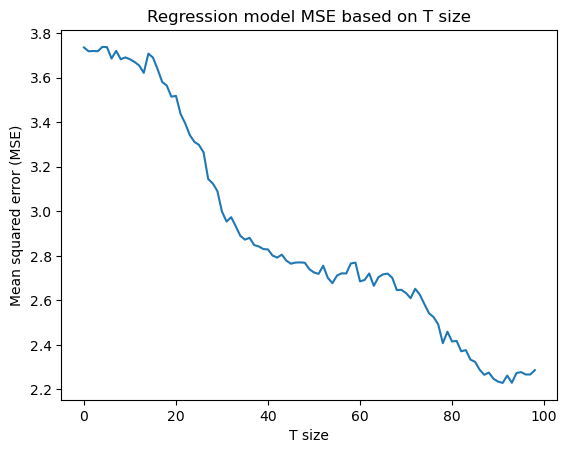

(2.765442417012659, 3.7373477864209845, 2.2295010264986685, 2.8945922137308218)

In [14]:
losses=[]
t=time.time()
for t in range(1,100):
    X_,y_=gen_temporal_data(X,y_,t)
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_test)

    # Calculate Mean Squared Error (MSE) to evaluate the model
    mse = mean_squared_error(Y_test, Y_pred)
    losses.append(mse)
print("Time taken",time.time()-t)
plt.plot(losses)
plt.title("Regression model MSE based on T size")
plt.ylabel("Mean squared error (MSE)")
plt.xlabel("T size")
plt.show()
np.median(losses),np.max(losses),np.min(losses),np.average(losses)

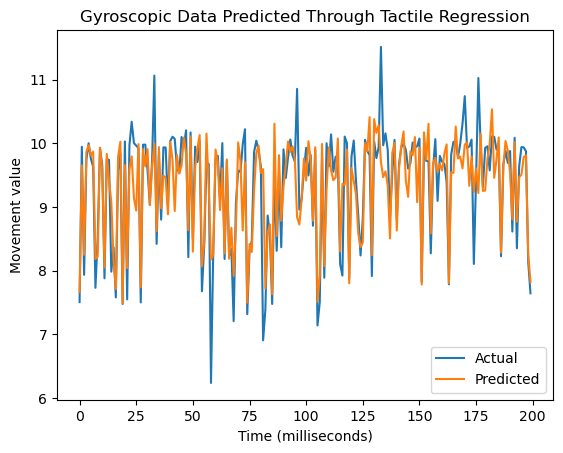

In [87]:
Y_pred = ridge_model.predict(X_train)
plt.plot(Y_train[:,0][0:200],label="Actual")
plt.plot(Y_pred[:,0][0:200],label="Predicted")

plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()

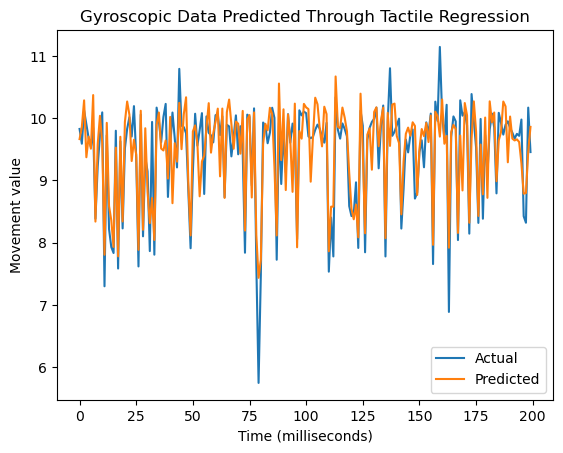

In [86]:
Y_pred = ridge_model.predict(X_test)
plt.plot(Y_test[:,0][0:200],label="Actual")
plt.plot(Y_pred[:,0][0:200],label="Predicted")


plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()


In [ ]:

"""
plt.plot(Y_pred[:,1][0:200],label="Predicted")
plt.plot(Y_test[:,1][0:200],label="Actual")
plt.plot(Y_pred[:,2][0:200],label="Predicted")
plt.plot(Y_test[:,2][0:200],label="Actual")
"""

#### Without vibration

In [16]:
X,y=sort_data("accmovementLeftFoot.csv",False)
X1,y1=sort_data("accmovementRightFoot.csv",False)
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)

X data: (4444, 4) /ny data: (4444, 3)
X data: (12719, 4) /ny data: (12719, 3)


Mean Squared Error: 3.61771


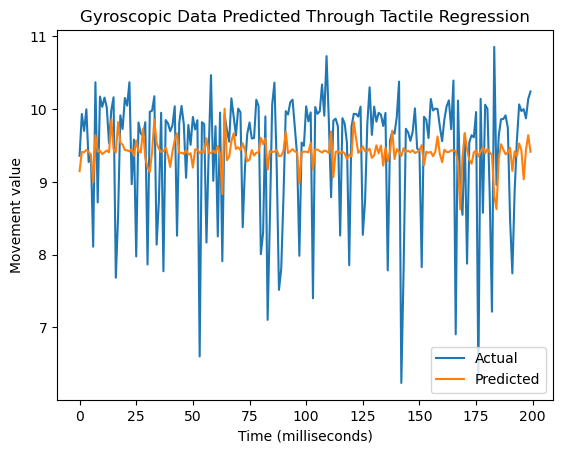

In [4]:

X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
ridge_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
ridge_model.fit(X_train, Y_train)

# Make predictions on the test data
Y_pred = ridge_model.predict(X_test)

# Calculate Mean Squared Error (MSE) to evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

Y_pred = ridge_model.predict(X_train)
plt.plot(Y_train[:,0][0:200],label="Actual")
plt.plot(Y_pred[:,0][0:200],label="Predicted")

plt.title("Gyroscopic Data Predicted Through Tactile Regression")
plt.ylabel("Movement value")
plt.xlabel("Time (milliseconds)")
plt.legend(loc="lower right")
plt.show()

Time taken 1699885774.0101852


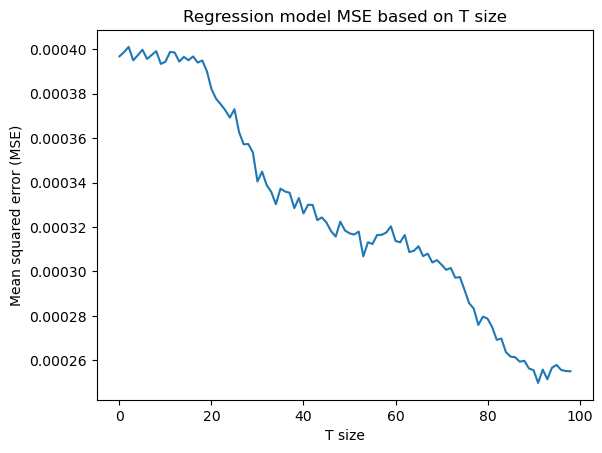

In [17]:
losses=[]
t=time.time()
for t in range(1,100):
    X_,y_=gen_temporal_data(X,y_,t)
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_test)

    # Calculate Mean Squared Error (MSE) to evaluate the model
    mse = mean_squared_error(Y_test, Y_pred)
    losses.append(mse/10000)
print("Time taken",time.time()-t)
plt.plot(losses)
plt.title("Regression model MSE based on T size")
plt.ylabel("Mean squared error (MSE)")
plt.xlabel("T size")
plt.show()

In [10]:
np.median(losses),np.max(losses),np.min(losses),np.average(losses)

(3.181082132055287, 4.010584362344202, 2.498352895845421, 3.264211665425633)

#### Texture study

In [74]:
X,y=sort_data("accmovementLeftFoot.csv")
X1,y1=sort_data("accmovementRightFoot.csv")
X=np.concatenate((X,X1),axis=0)
y=np.concatenate((y,y1),axis=0)
X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)
# Create a Ridge Regression model
alpha = 1.0  # Ridge regularization parameter (adjust as needed)
normal_model = Ridge(alpha=alpha)
#ridge_model = LinearRegression(positive=True)
# Fit the model to the training data
normal_model.fit(X_train, Y_train)
# Make predictions on the test data
Y_pred = normal_model.predict(X_test)
# Calculate Mean Squared Error (MSE) to evaluate the model
mse_norm = mean_squared_error(Y_test, Y_pred)
print(f"Mean Squared Error: {mse:.5f}")

def getMSEData(nameLeft,nameRight,model):
    X,y=sort_data(nameLeft)
    X1,y1=sort_data(nameRight)
    X=np.concatenate((X,X1),axis=0)
    y=np.concatenate((y,y1),axis=0)

    y_pred = model.predict(X)
    return mean_squared_error(y, y_pred)
mse_texture=getMSEData("accmovementLeftFootCarpet.csv","accmovementRightFootCarpet.csv",normal_model)
print("Normal MSE:",mse_norm,"\n\nCarpet MSE:",mse_texture)

X data: (4444, 6) /ny data: (4444, 3)
X data: (12719, 6) /ny data: (12719, 3)
Mean Squared Error: 2.55085


FileNotFoundError: [Errno 2] No such file or directory: '/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/accmovementLeftFootTexture.csv'

### LSTM

In [3]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagation
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out


#### Prep data

In [30]:
#prep data
def getData(X,y,T):
    X_,y_=gen_temporal_data_2(X,y,T)
    #reduction
    X_=(X_-np.average(X_))/np.std(X_)
    y=(y-np.average(y))/np.std(y)
    #split
    X_train, X_test, Y_train, Y_test = train_test_split(X_.astype(np.float32)[0:100], y_.astype(np.float32)[0:100], test_size=0.2, random_state=42)
    X_train=torch.tensor(X_train).to(device)
    X_test=torch.tensor(X_test).to(device)
    Y_train=torch.tensor(Y_train).to(device)
    Y_test=torch.tensor(Y_test).to(device)
    return X_train, X_test, Y_train, Y_test
X_train, X_test, Y_train, Y_test=getData(X,y,5)

In [5]:
# Example usage:
input_size = 6
hidden_size = 64
num_layers = 2
output_size = 3

lstm_model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

n = 10
input_data = X_train[0:n]
print(input_data.shape,input_data.dtype)
output = lstm_model(input_data)
print("LSTM Output:", output)

torch.Size([10, 5, 6]) torch.float32
LSTM Output: tensor([[ 0.0404, -0.0572,  0.0432],
        [ 0.0417, -0.0499,  0.0383],
        [ 0.0377, -0.0589,  0.0426],
        [ 0.0386, -0.0527,  0.0406],
        [ 0.0420, -0.0555,  0.0406],
        [ 0.0393, -0.0404,  0.0394],
        [ 0.0410, -0.0558,  0.0414],
        [ 0.0412, -0.0447,  0.0383],
        [ 0.0361, -0.0472,  0.0418],
        [ 0.0449, -0.0617,  0.0422]], grad_fn=<AddmmBackward0>)


#### Training

In [9]:
def train(X_train,Y_train,X_test,Y_test,num_epochs = 100,learning_rate = 0.001):
    # Split your dataset into training and validation sets
    # train_data, val_data = ...
    lstm_model=LSTMModel(X_train.shape[2],50,2,Y_train.shape[1]).to(device)
    # Create data loaders for training and validation

    # Initialize the optimizer
    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    history_train=[]
    history_test=[]
    # Training loop
    for epoch in range(num_epochs):
        lstm_model.train()

        optimizer.zero_grad()
        # Forward pass
        outputs = lstm_model(X_train)

        # Calculate the loss
        loss = criterion(outputs, Y_train)

        # Backpropagation
        loss.backward()
        optimizer.step()

        total_loss = loss.item()
        history_train.append(total_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}")

        # Validation
        lstm_model.eval()
        with torch.no_grad():
            total_val_loss = 0

            outputs = lstm_model(X_test)
            val_loss = criterion(outputs, Y_test)
            total_val_loss = val_loss.item()

            print(f"Validation Loss: {total_val_loss:.4f}")
            history_test.append(total_val_loss)
    # Save the trained model
    #torch.save(lstm_model.state_dict(), "lstm_model.pth")
    return history_train, history_test

lossTrain,lossTest=train(X_train,Y_train,X_test,Y_test,num_epochs = 1000,learning_rate = 0.01)

Epoch [1/1000], Loss: 37.5065
Validation Loss: 39.4443
Epoch [2/1000], Loss: 37.3708
Validation Loss: 39.5628
Epoch [3/1000], Loss: 37.1869
Validation Loss: 39.6825
Epoch [4/1000], Loss: 36.8560
Validation Loss: 39.6113
Epoch [5/1000], Loss: 36.2735
Validation Loss: 39.0104
Epoch [6/1000], Loss: 35.4710
Validation Loss: 38.2079
Epoch [7/1000], Loss: 34.7100
Validation Loss: 37.6412
Epoch [8/1000], Loss: 34.0141
Validation Loss: 37.7721
Epoch [9/1000], Loss: 33.4534
Validation Loss: 36.9035
Epoch [10/1000], Loss: 32.6880
Validation Loss: 36.0081
Epoch [11/1000], Loss: 31.8977
Validation Loss: 35.1913
Epoch [12/1000], Loss: 31.4384
Validation Loss: 34.8082
Epoch [13/1000], Loss: 30.6223
Validation Loss: 34.1416
Epoch [14/1000], Loss: 30.0191
Validation Loss: 33.4474
Epoch [15/1000], Loss: 29.1958
Validation Loss: 32.6653
Epoch [16/1000], Loss: 28.3721
Validation Loss: 32.0670
Epoch [17/1000], Loss: 27.3750
Validation Loss: 31.2717
Epoch [18/1000], Loss: 26.6203
Validation Loss: 30.7471
E

#### Opening data

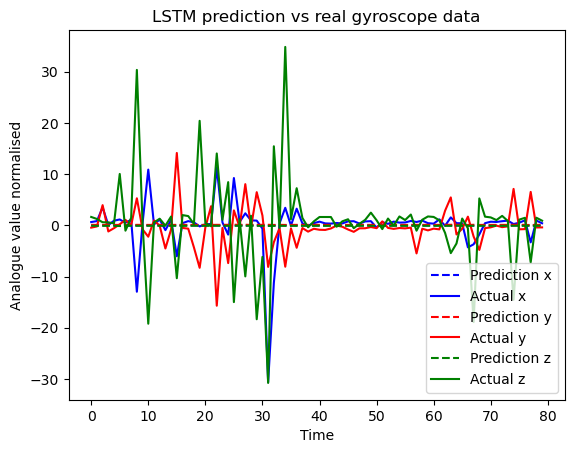

2.9940157

In [50]:
X_train, X_test, Y_train, Y_test=getData(X,y,1)
lstm_model=LSTMModel(X_train.shape[2],50,2,Y_train.shape[1]).to(device)
lstm_model.load_state_dict(torch.load(path+"GPUCluster/data/lstm_model.pth",map_location=torch.device('cpu')))
outputs = lstm_model(X_train)

plt.plot(outputs[:,0].cpu().detach().numpy(),"--",c="b",label="Prediction x")
plt.plot(Y_train[:,0].cpu().detach().numpy(),c="b",label="Actual x")

plt.plot(outputs[:,1].cpu().detach().numpy(),"--",c="r",label="Prediction y")
plt.plot(Y_train[:,1].cpu().detach().numpy(),c="r",label="Actual y")

plt.plot(outputs[:,2].cpu().detach().numpy(),"--",c="g",label="Prediction z")
plt.plot(Y_train[:,2].cpu().detach().numpy(),c="g",label="Actual z")
plt.xlabel("Time")
plt.ylabel("Analogue value normalised")
plt.title("LSTM prediction vs real gyroscope data")
plt.legend(loc="lower right")
plt.show()
np.average(np.abs(outputs.detach().numpy()-Y_train.detach().numpy()))

[2.9940157, 2.9824908, 2.965934, 2.9483712, 2.9346056, 2.9294667, 2.9319146, 2.9334247, 2.933404, 2.9260583, 2.918158, 2.9097064, 2.8919957, 2.875303, 2.8559835, 2.854029, 2.8592684, 2.8687835, 2.8707442, 2.8689225, 2.868931, 2.871277, 2.8762708, 2.8775403, 2.879662, 2.8792796, 2.8790755, 2.876801, 2.8779988]


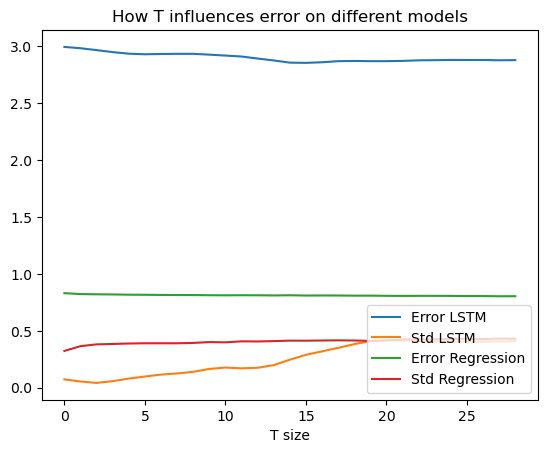

In [51]:
ar=[]
std=[]
ar1=[]
std1=[]
for i in range(1,30):
    X_train, X_test, Y_train, Y_test=getData(X,y,i)
    outputs = lstm_model(X_train)
    ar.append(np.average(np.abs(outputs.detach().numpy()-Y_train.detach().numpy())))
    std.append(np.std(outputs.detach().numpy()))
    
    X_,y_=gen_temporal_data(X,y,i)
    y_=y_[:,2]
    X_train, X_test, Y_train, Y_test = train_test_split(X_, y_, test_size=0.2, random_state=42)

    # Create a Ridge Regression model
    alpha = 1.0  # Ridge regularization parameter (adjust as needed)
    ridge_model = Ridge(alpha=alpha)
    #ridge_model = LinearRegression(positive=True)
    # Fit the model to the training data
    ridge_model.fit(X_train, Y_train)

    # Make predictions on the test data
    Y_pred = ridge_model.predict(X_train)

    ar1.append(np.average(np.abs(Y_pred-Y_train)))
    std1.append(np.std(Y_pred))

print(ar)
plt.plot(ar,label="Error LSTM")
plt.plot(std,label="Std LSTM")
plt.plot(ar1,label="Error Regression")
plt.plot(std1,label="Std Regression")
plt.title("How T influences error on different models")
plt.xlabel("T size")
plt.legend(loc="lower right")
plt.show()

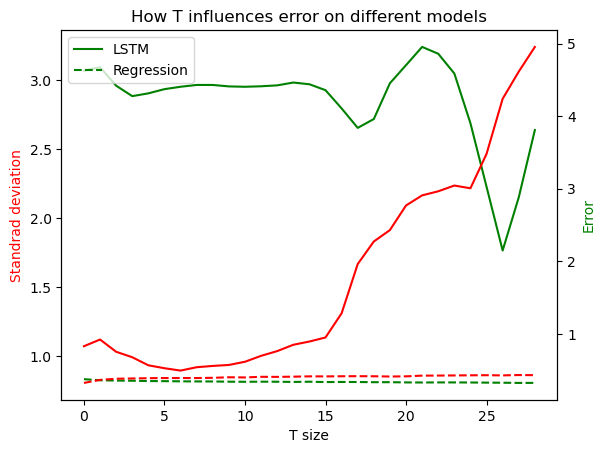

In [49]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(ar,c="g",label="LSTM")
ax2.plot(std,c="r",label="Std LSTM")
ax1.plot(ar1,"--",c="g",label="Regression")
ax2.plot(std1,"--",c="r",label="Std Regression")

ax1.set_xlabel('T size')
ax1.set_ylabel('Standrad deviation', color='r')
ax2.set_ylabel('Error', color='g')
ax1.set_title("How T influences error on different models")

ax1.legend(loc="upper left")

### Visualisation 

/tmp/ipykernel_30344/3896005188.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab20')  # You can choose different colormaps


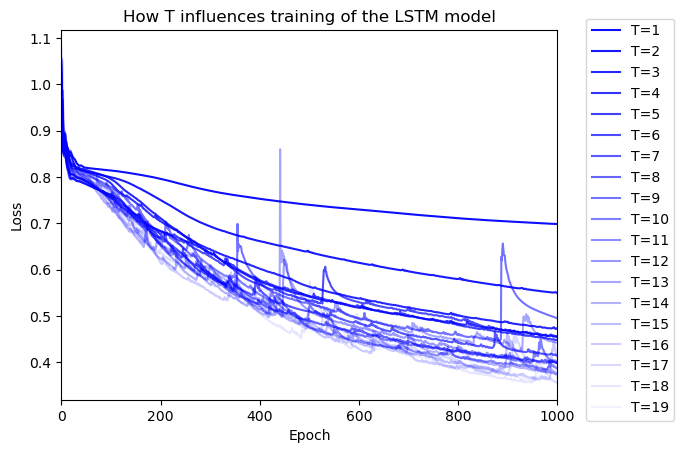

In [37]:
from matplotlib.cm import get_cmap
cmap = get_cmap('tab20')  # You can choose different colormaps

filename="train_loss_t="

typ=".npy"
for i in range(1,20):
    shade=i/20
    data=np.load("/its/home/drs25/Documents/GitHub/TactileSensor/Code/Data collection/robot/GPUCluster/data/"+filename+str(i)+"_"+typ)
    plt.plot(data,label="T="+str(i),color="b",alpha=1 - shade)

plt.title("How T influences training of the LSTM model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper right",bbox_to_anchor=(1.25, 1.05))
plt.xlim([0,1000])
plt.show()

X data: (4444, 3) /ny data: (4444, 3)
X data: (12719, 3) /ny data: (12719, 3)


/tmp/ipykernel_4303/2142451300.py:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='Left foot pressures')
/tmp/ipykernel_4303/2142451300.py:23: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(plt.cm.ScalarMappable(cmap='Greens'), label='Right foot pressures')


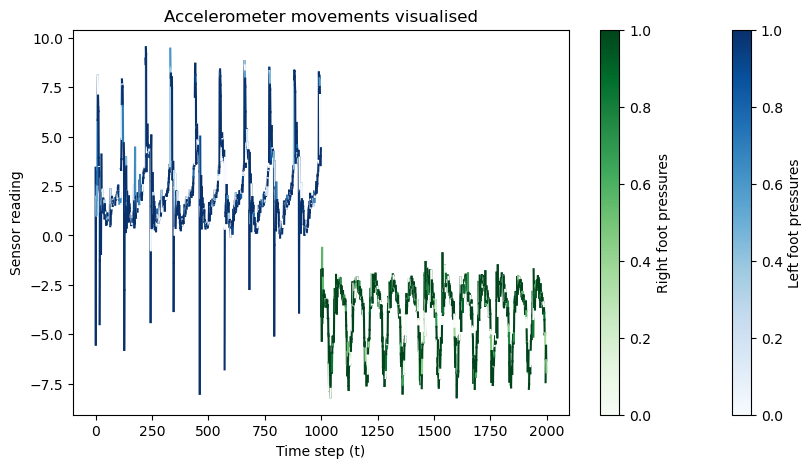

In [71]:
X,y=sort_data("accmovementLeftFoot.csv",dir="left")
#X1,y1=sort_data("movementLeftFoot1.csv")
#X=np.concatenate((X,X1),axis=0)
#y=np.concatenate((y,y1),axis=0)
axis=1
maxsize=1000
colors = np.max(X[0:maxsize],axis=1)
plt.figure(figsize=(10, 5))  # Width: 10 units, Height: 5 units

xx=[i for i in range(maxsize)]
for i in range(len(xx) - 1):
    plt.plot(xx[i:i+2], y[i:i+2,axis], color=plt.cm.Blues(colors[i]))

X1,y1=sort_data("accmovementRightFoot.csv",dir="right")
colors = np.max(X1[0:maxsize],axis=1)
xx=[i for i in range(maxsize,maxsize+maxsize)]
for i in range(len(xx) - 1):
    plt.plot(xx[i:i+2], y1[i:i+2,axis], color=plt.cm.Greens(colors[i]))

plt.title("Accelerometer movements visualised")
plt.xlabel("Time step (t)")
plt.colorbar(plt.cm.ScalarMappable(cmap='Blues'), label='Left foot pressures')
plt.colorbar(plt.cm.ScalarMappable(cmap='Greens'), label='Right foot pressures')
plt.ylabel("Sensor reading")
plt.show()

In [60]:
dir(plt.cm)

['Accent',
 'Accent_r',
 'Blues',
 'Blues_r',
 'BrBG',
 'BrBG_r',
 'BuGn',
 'BuGn_r',
 'BuPu',
 'BuPu_r',
 'CMRmap',
 'CMRmap_r',
 'ColormapRegistry',
 'Dark2',
 'Dark2_r',
 'GnBu',
 'GnBu_r',
 'Greens',
 'Greens_r',
 'Greys',
 'Greys_r',
 'Mapping',
 'OrRd',
 'OrRd_r',
 'Oranges',
 'Oranges_r',
 'PRGn',
 'PRGn_r',
 'Paired',
 'Paired_r',
 'Pastel1',
 'Pastel1_r',
 'Pastel2',
 'Pastel2_r',
 'PiYG',
 'PiYG_r',
 'PuBu',
 'PuBuGn',
 'PuBuGn_r',
 'PuBu_r',
 'PuOr',
 'PuOr_r',
 'PuRd',
 'PuRd_r',
 'Purples',
 'Purples_r',
 'RdBu',
 'RdBu_r',
 'RdGy',
 'RdGy_r',
 'RdPu',
 'RdPu_r',
 'RdYlBu',
 'RdYlBu_r',
 'RdYlGn',
 'RdYlGn_r',
 'Reds',
 'Reds_r',
 'ScalarMappable',
 'Set1',
 'Set1_r',
 'Set2',
 'Set2_r',
 'Set3',
 'Set3_r',
 'Spectral',
 'Spectral_r',
 'Wistia',
 'Wistia_r',
 'YlGn',
 'YlGnBu',
 'YlGnBu_r',
 'YlGn_r',
 'YlOrBr',
 'YlOrBr_r',
 'YlOrRd',
 'YlOrRd_r',
 '_LUTSIZE',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',

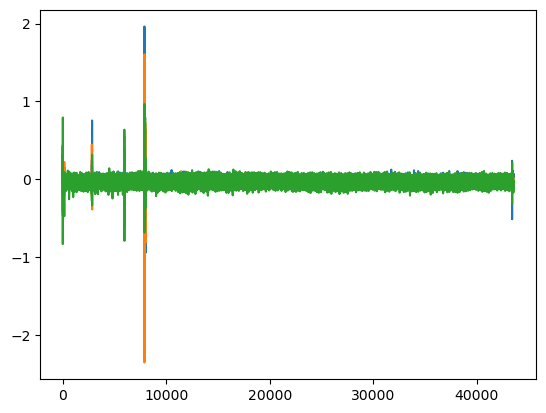

In [3]:
plt.plot(df['x'][FROM:TO])
plt.plot(df['y'][FROM:TO])
plt.plot(df['z'][FROM:TO])
plt.show()